# Tutorial for classification

In this tutorial, we compare the prediction sets estimated by the conformal methods implemented in MAPIE on a toy two-dimensional dataset.

Throughout this tutorial, we will answer the following questions:

- How does the number of classes in the prediction sets vary according to the significance level ?

- Is the chosen conformal method well calibrated ?

- What are the pros and cons of the conformal methods included in MAPIE ?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from mapie.classification import MapieClassifier
from mapie.metrics import (
    classification_coverage_score, classification_mean_width_score
)

## 1. Conformal Prediction method using the softmax score of true label

MAPIE can estimate a prediction set of several classes such that the probability that the true label of a new test point is included in the prediction set is always higher than the target confidence interval level:

$$ P(Y_{n+1} \in \hat{C_{n,\alpha}}(X_{n+1})) \ge 1 - \alpha $$

We start by using the softmax score output by the clasifier as the conformity score on a toy two-dimensional dataset.

We estimate the prediction sets as follows:

- Generate a dataset with train, calibration and test, the model is fitted on the training set.
- Set the conformal score $S_{i} = \hat{f(X_{i})_{y_{i}}}$ the softmax output of the true class for each sample in the calibration set.
- Define $\hat{q}$ as the being the $(n+1)(\alpha)/n$ previous quantile of $S_{1},..., S_{n}$ (this is essentially the quantile $\alpha$, but with a small correction)
- Finally, for a new test data point (where $X_{n+1}$ is known but $Y_{n+1}$ is not), create a prediction set $ C(X_{n+1}) = y: {\hat{f(X_{n+1})}_{y} > \hat{q}}$ which includes all the classes with a sufficiently high softmax output.

In [2]:
# We use a two-dimensional toy dataset with three labels. The distribution of
# the data is a bivariate normal with diagonal covariance matrices for each
# label.

centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
n_samples = 1000
n_classes = 3
np.random.seed(42)
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y = np.hstack([np.full(n_samples, i) for i in range(n_classes)])
X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25
)

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

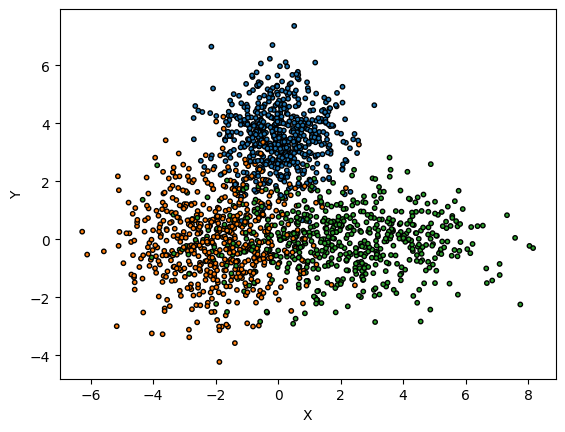

In [3]:
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker='o',
    s=10,
    edgecolor='k'
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

We fit our training data with a Gaussian Naive Base estimator. And then we apply MAPIE in the calibration data with the method **score** to the estimator indicating that it has already been fitted with cv=”prefit”. We then estimate the prediction sets with differents alpha values with a **fit** and **predict** process.

In [4]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test_mesh, alpha=alpha)

In [5]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

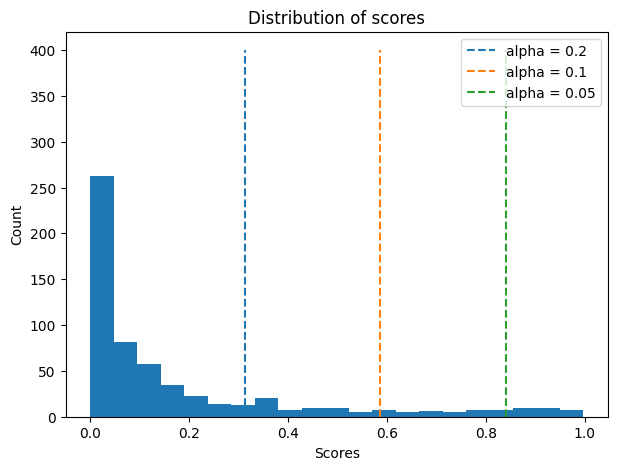

In [6]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_
plot_scores(n, alpha, scores, quantiles)

The estimated quantile increases with alpha. A high value of alpha can potentially lead to a high quantile which would not necessarily be reached by any class in uncertain areas, resulting in null regions.

We will now visualize the differences between the prediction sets of the different values of alpha.

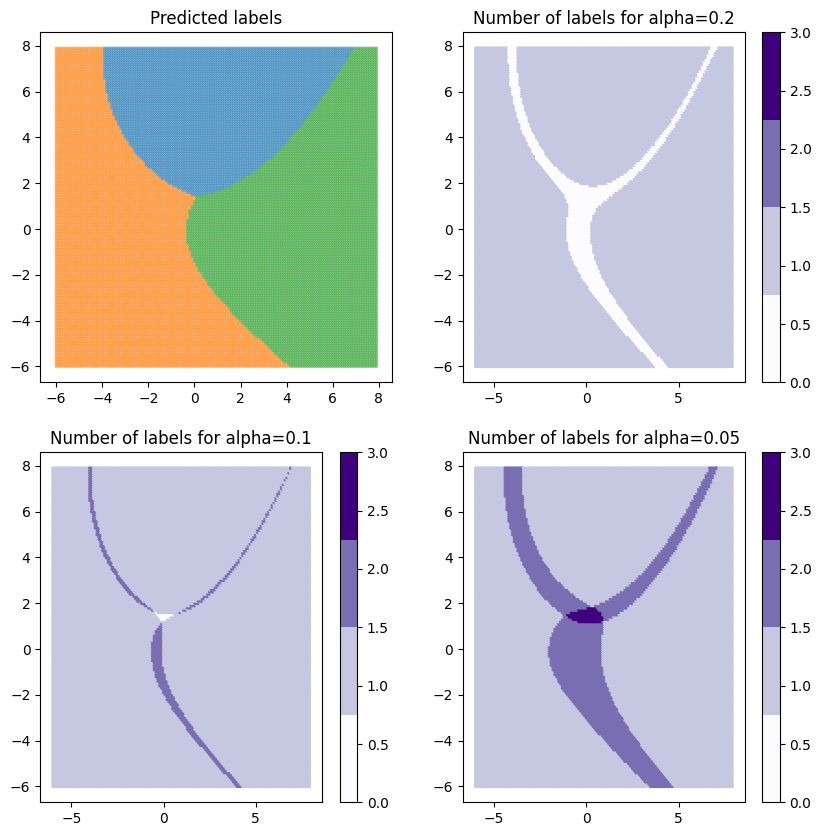

In [7]:
def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.get_cmap('Purples', 4)
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
    axs = {0: ax1, 1: ax2, 2:  ax3, 3: ax4}
    axs[0].scatter(
        X[:, 0],
        X[:, 1],
        color=y_pred_col,
        marker='.',
        s=10,
        alpha=0.4
    )
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i+1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3
        )
        plt.colorbar(num_labels, ax=axs[i+1])
        axs[i+1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()


plot_results(alpha, X_test_mesh, y_pred_score, y_ps_score)

Let’s now study the effective coverage and the mean prediction set widths as function of the $1-\alpha$ target coverage. To this aim, we use once again the **predict** method of **MAPIE** to estimate predictions sets on a large number of $\alpha$ values.

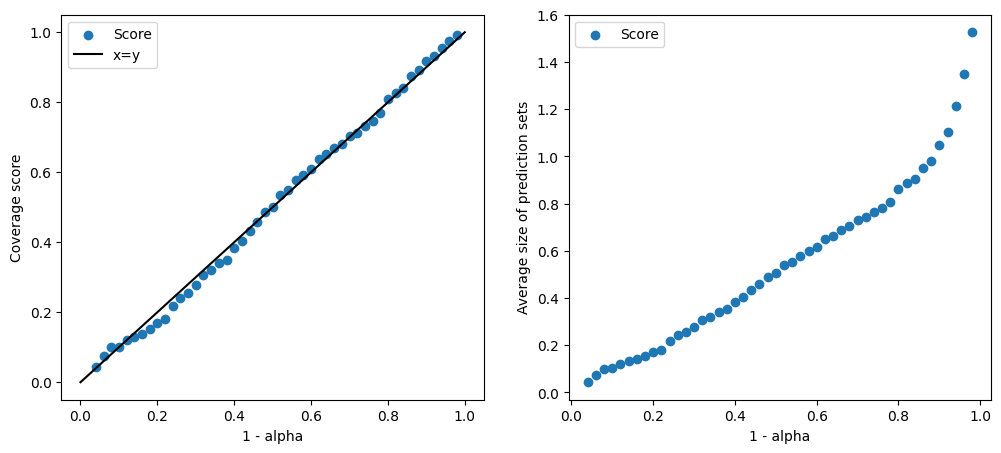

In [8]:
alpha2 = np.arange(0.02, 0.98, 0.02)
_, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
coverages_score = [
    classification_coverage_score(y_test, y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_score = [
    classification_mean_width_score(y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]


def plot_coverages_widths(alpha, coverage, width, method):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(1 - alpha, coverage, label=method)
    axs[0].set_xlabel("1 - alpha")
    axs[0].set_ylabel("Coverage score")
    axs[0].plot([0, 1], [0, 1], label="x=y", color="black")
    axs[0].legend()
    axs[1].scatter(1 - alpha, width, label=method)
    axs[1].set_xlabel("1 - alpha")
    axs[1].set_ylabel("Average size of prediction sets")
    axs[1].legend()
    plt.show()


plot_coverages_widths(alpha2, coverages_score, widths_score, "Score")

## 2. Conformal Prediction method using the cumulative softmax score

We saw in the previous section that the “score” method is well calibrated by providing accurate coverage levels. However, it tends to give null prediction sets for uncertain regions, especially when the $\alpha$ value is high. **MAPIE** includes another method, called **Adaptive Prediction Set (APS)**, whose conformity score is the cumulated score of the softmax output until the true label is reached (see the theoretical description for more details). We will see in this Section that this method no longer estimates null prediction sets but by giving slightly bigger prediction sets.

Let’s visualize the prediction sets obtained with the APS method on the test set after fitting MAPIE on the calibration set.

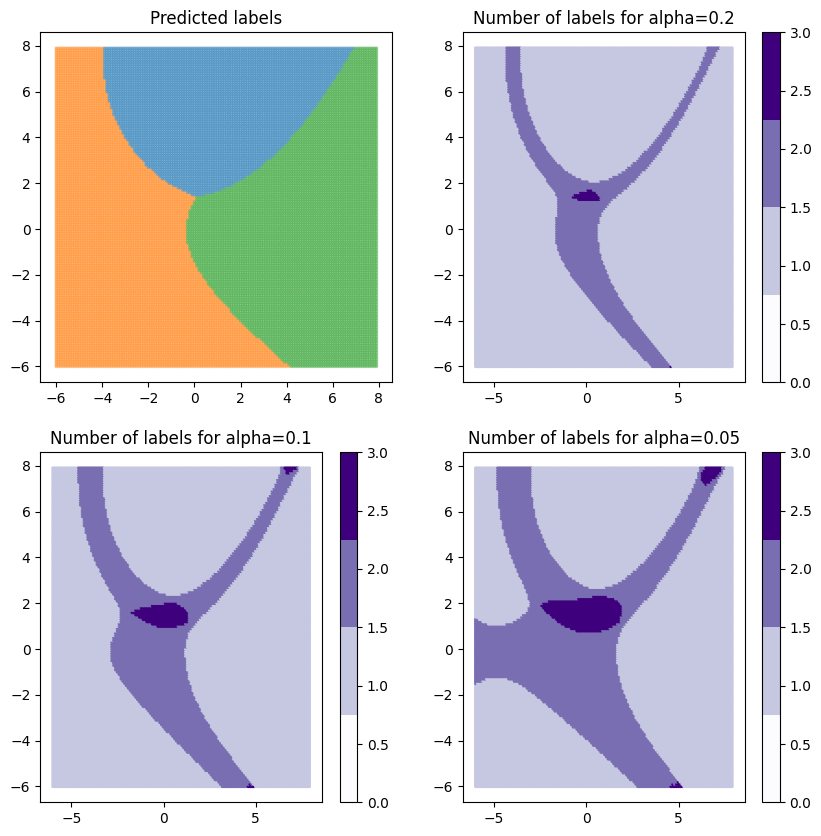

In [9]:
mapie_aps = MapieClassifier(
    estimator=clf, cv="prefit", method="cumulated_score"
)
mapie_aps.fit(X_cal, y_cal)
alpha = [0.2, 0.1, 0.05]
y_pred_aps, y_ps_aps = mapie_aps.predict(
    X_test_mesh, alpha=alpha, include_last_label=True
)

plot_results(alpha, X_test_mesh, y_pred_aps, y_ps_aps)

One can notice that the uncertain regions are emphasized by wider boundaries, but without null prediction sets with respect to the first “score” method.

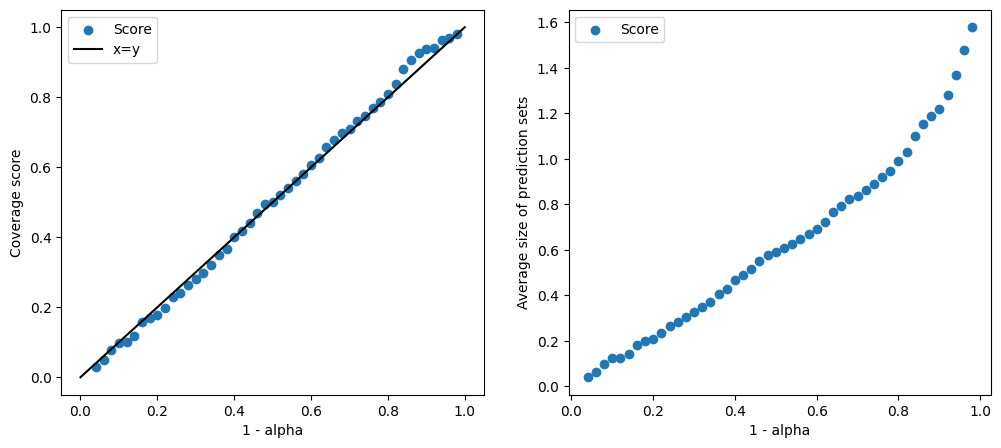

In [10]:
_, y_ps_aps2 = mapie_aps.predict(
    X_test, alpha=alpha2, include_last_label="randomized"
)
coverages_aps = [
    classification_coverage_score(y_test, y_ps_aps2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_aps = [
    classification_mean_width_score(y_ps_aps2[:, :, i])
    for i, _ in enumerate(alpha2)
]

plot_coverages_widths(alpha2, coverages_aps, widths_aps, "Score")

# Cross-conformal for classification

In this tutorial, we estimate the impact of the training/calibration split on the prediction sets and on the resulting coverage estimated by **MapieClassifier**. We then adopt a cross-validation approach in which the conformity scores of all calibration sets are used to estimate the quantile. We demonstrate that this second “cross-conformal” approach gives more robust prediction sets with accurate calibration plots.

We start the tutorial by splitting our training dataset in **K** folds and sequentially use each fold as a calibration set, the **K-1** folds remaining folds are used for training the base model using the **cv="prefit"** option of **MapieClassifier**.

In [11]:
from typing import Dict, Any, Optional, Union, List
from typing_extensions import TypedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from mapie.classification import MapieClassifier
from mapie.metrics import (
    classification_coverage_score,
    classification_mean_width_score
)
from mapie._typing import NDArray

## 1. Estimating the impact of train/calibration split on the prediction sets

We start by generating the two-dimensional dataset and extracting training and test sets. Two test sets are created, one with the same distribution as the training set and a second one with a regular mesh for visualization. The dataset is two-dimensional with three classes, data points of each class are obtained from a normal distribution.

In [12]:
centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [[[1, 0], [0, 1]], [[2, 0], [0, 2]], [[5, 0], [0, 1]]]
x_min, x_max, y_min, y_max, step = -5, 7, -5, 7, 0.1
n_samples = 500
n_classes = 3
n_cv = 5
np.random.seed(42)

X_train = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y_train = np.hstack([np.full(n_samples, i) for i in range(n_classes)])

X_test_distrib = np.vstack([
    np.random.multivariate_normal(center, cov, 10*n_samples)
    for center, cov in zip(centers, covs)
])
y_test_distrib = np.hstack(
    [np.full(10*n_samples, i) for i in range(n_classes)]
)

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test = np.stack([xx.ravel(), yy.ravel()], axis=1)

Let’s visualize the two-dimensional dataset.

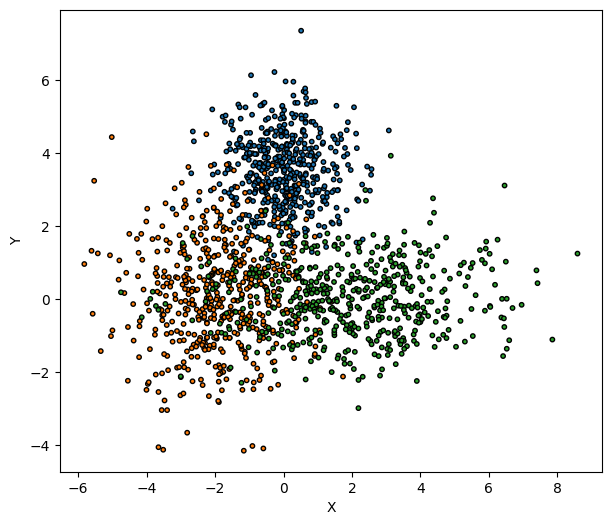

In [14]:
colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3: "#d62728"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure(figsize=(7, 6))
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker="o",
    s=10,
    edgecolor="k",
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

We split our training dataset into 5 folds and use each fold as a calibration set. Each calibration set is therefore used to estimate the conformity scores and the given quantiles for the two methods implemented in **MapieClassifier**.

In [15]:
kf = KFold(n_splits=5, shuffle=True)
clfs, mapies, y_preds, y_ps_mapies = {}, {}, {}, {}
methods = ["score", "cumulated_score"]
alpha = np.arange(0.01, 1, 0.01)
for method in methods:
    clfs_, mapies_, y_preds_, y_ps_mapies_ = {}, {}, {}, {}
    for fold, (train_index, calib_index) in enumerate(kf.split(X_train)):
        clf = GaussianNB().fit(X_train[train_index], y_train[train_index])
        clfs_[fold] = clf
        mapie = MapieClassifier(estimator=clf, cv="prefit", method=method)
        mapie.fit(X_train[calib_index], y_train[calib_index])
        mapies_[fold] = mapie
        y_pred_mapie, y_ps_mapie = mapie.predict(
            X_test_distrib, alpha=alpha, include_last_label="randomized"
        )
        y_preds_[fold], y_ps_mapies_[fold] = y_pred_mapie, y_ps_mapie
    clfs[method], mapies[method], y_preds[method], y_ps_mapies[method] = (
        clfs_, mapies_, y_preds_, y_ps_mapies_
    )

Let’s now plot the distribution of conformity scores for each calibration set and the estimated quantile for $\alpha$ = 0.1.

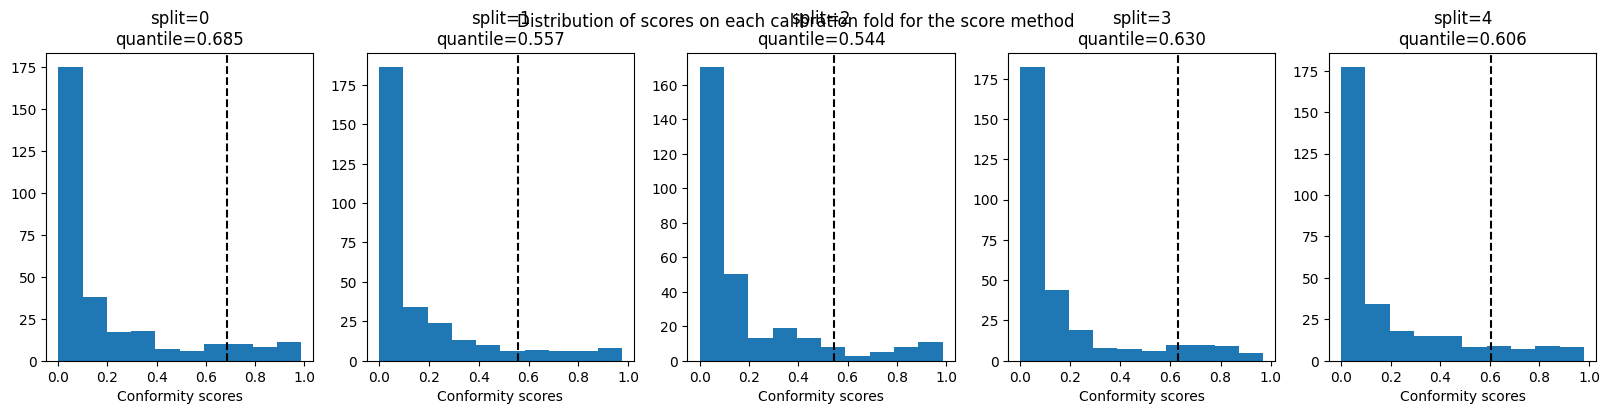

In [16]:
fig, axs = plt.subplots(1, len(mapies["score"]), figsize=(20, 4))
for i, (key, mapie) in enumerate(mapies["score"].items()):
    axs[i].set_xlabel("Conformity scores")
    axs[i].hist(mapie.conformity_scores_)
    axs[i].axvline(mapie.quantiles_[9], ls="--", color="k")
    axs[i].set_title(f"split={key}\nquantile={mapie.quantiles_[9]:.3f}")
plt.suptitle(
    "Distribution of scores on each calibration fold for the "
    f"{methods[0]} method"
)
plt.show()

We notice that the estimated quantile slightly varies among the calibration sets for the two methods explored here, suggesting that the train/calibration splitting can slightly impact our results.

Let’s now visualize this impact on the number of labels included in each prediction set induced by the different calibration sets.

In [17]:
def plot_results(
    mapies: Dict[int, Any],
    X_test: NDArray,
    X_test2: NDArray,
    y_test2: NDArray,
    alpha: float,
    method: str
) -> None:
    tab10 = plt.cm.get_cmap('Purples', 4)
    fig, axs = plt.subplots(1, len(mapies), figsize=(20, 4))
    for i, (_, mapie) in enumerate(mapies.items()):
        y_pi_sums = mapie.predict(
            X_test,
            alpha=alpha,
            include_last_label=True
        )[1][:, :, 0].sum(axis=1)
        axs[i].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3
        )
        coverage = classification_coverage_score(
            y_test2, mapie.predict(X_test2, alpha=alpha)[1][:, :, 0]
        )
        axs[i].set_title(f"coverage = {coverage:.3f}")
    plt.suptitle(
        "Number of labels in prediction sets "
        f"for the {method} method"
    )
    plt.show()

The prediction sets and the resulting coverages slightly vary among calibration sets. Let’s now visualize the coverage score and the prediction set size as function of the $\alpha$ parameter.

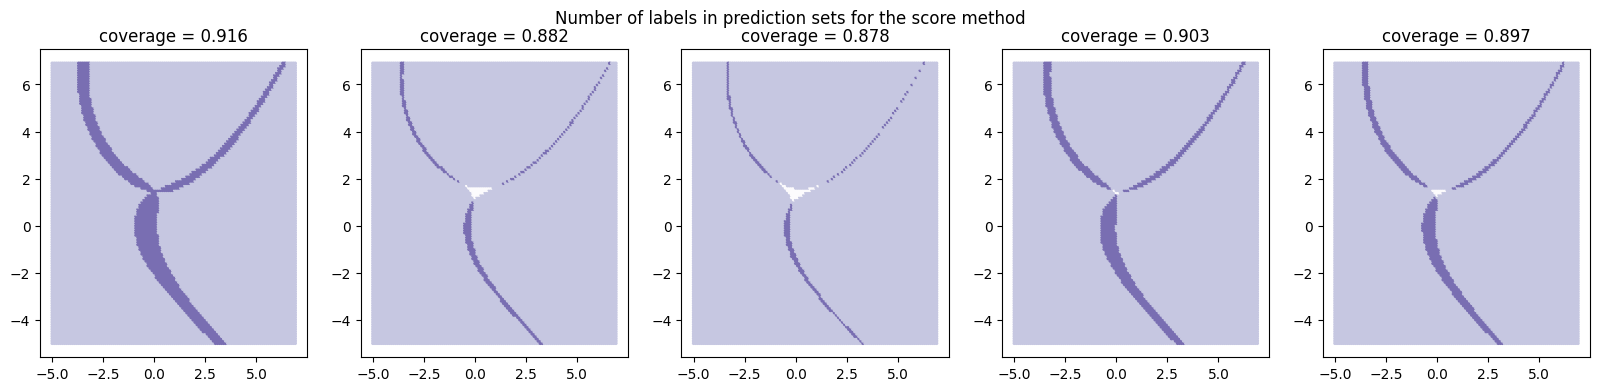

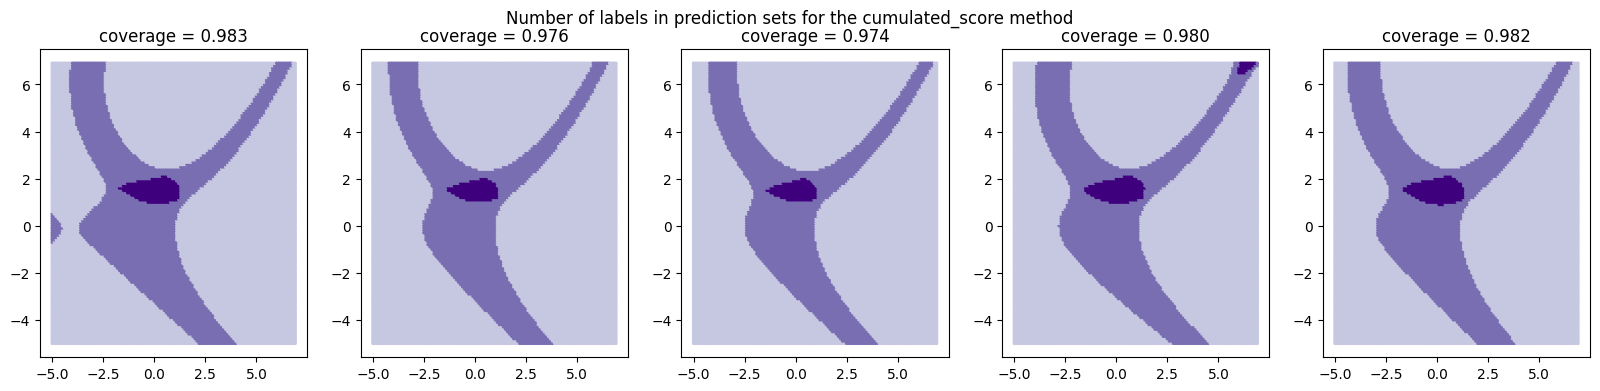

In [18]:
plot_results(
    mapies["score"],
    X_test,
    X_test_distrib,
    y_test_distrib,
    alpha[9],
    "score"
)

plot_results(
    mapies["cumulated_score"],
    X_test,
    X_test_distrib,
    y_test_distrib,
    alpha[9],
    "cumulated_score"
)

Let’s now compare the coverages and prediction set sizes obtained with the different folds used as calibration sets.

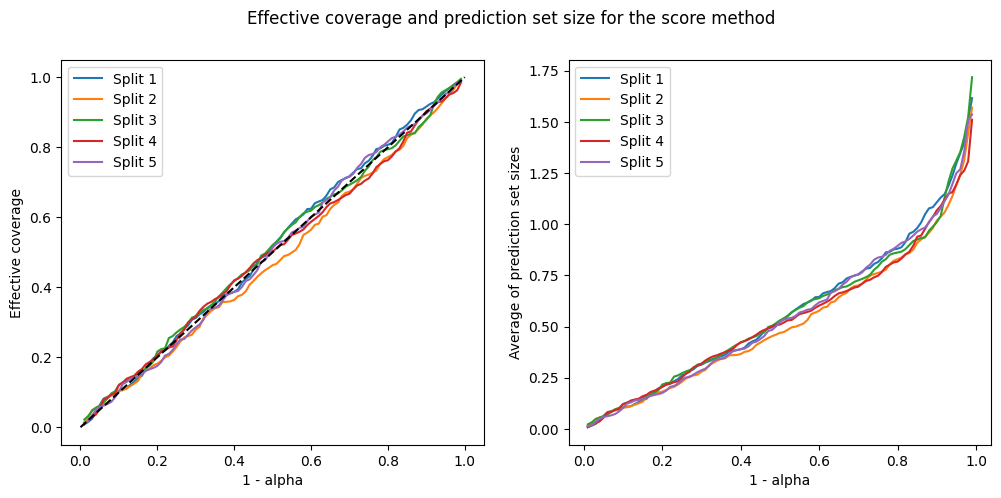

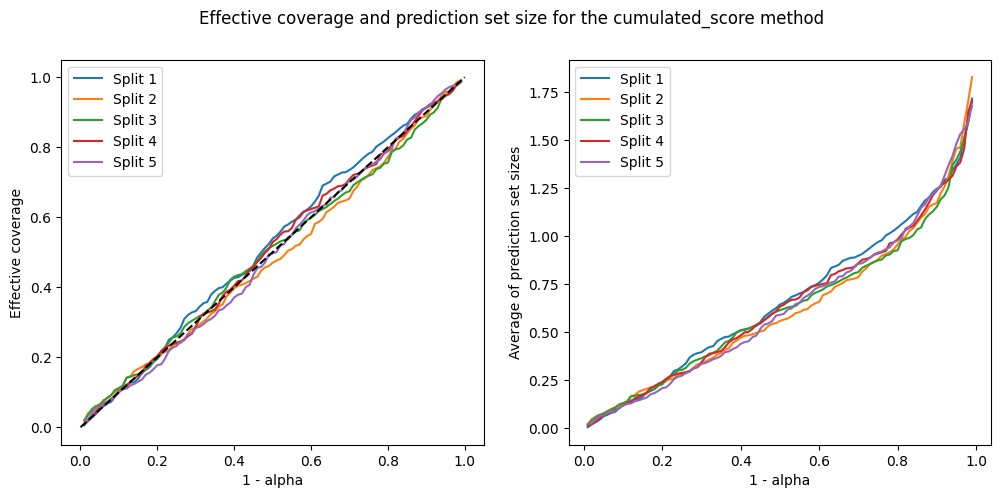

In [19]:
def plot_coverage_width(
    alpha: NDArray,
    coverages: List[NDArray],
    widths: List[NDArray],
    method: str,
    comp: str = "split"
) -> None:
    if comp == "split":
        legends = [f"Split {i + 1}" for i, _ in enumerate(coverages)]
    else:
        legends = ["Mean", "Crossval"]
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    axes[0].set_xlabel("1 - alpha")
    axes[0].set_ylabel("Effective coverage")
    for i, coverage in enumerate(coverages):
        axes[0].plot(1 - alpha, coverage, label=legends[i])
    axes[0].plot([0, 1], [0, 1], ls="--", color="k")
    axes[0].legend()
    axes[1].set_xlabel("1 - alpha")
    axes[1].set_ylabel("Average of prediction set sizes")
    for i, width in enumerate(widths):
        axes[1].plot(1 - alpha, width, label=legends[i])
    axes[1].legend()
    plt.suptitle(
        "Effective coverage and prediction set size "
        f"for the {method} method"
    )
    plt.show()


split_coverages = np.array(
    [
        [
            [
                classification_coverage_score(
                    y_test_distrib, y_ps[:, :, ia]
                ) for ia, _ in enumerate(alpha)]
            for _, y_ps in y_ps2.items()
        ] for _, y_ps2 in y_ps_mapies.items()
    ]
)

split_widths = np.array(
    [
        [
            [
                classification_mean_width_score(y_ps[:, :, ia])
                for ia, _ in enumerate(alpha)
            ]
            for _, y_ps in y_ps2.items()
        ] for _, y_ps2 in y_ps_mapies.items()
    ]
)

plot_coverage_width(
    alpha, split_coverages[0], split_widths[0], "score"
)

plot_coverage_width(
    alpha, split_coverages[1], split_widths[1], "cumulated_score"
)

One can notice that the train/calibration indeed impacts the coverage and prediction set.

In conclusion, the split-conformal method has two main limitations:

- It prevents us to use the whole training set for training our base model
- The prediction sets are impacted by the way we extract the calibration set

## 2. Aggregating the conformity scores through cross-validation

It is possible to “aggregate” the predictions through cross-validation mainly via two methods:

1. Aggregating the conformity scores for all training points and then simply averaging the scores output by the different perturbed models for a new test point

2. Comparing individually the conformity scores of the training points with the conformity scores from the associated model for a new test point (as presented in Romano et al. 2020 for the “cumulated_score” method)

Let’s explore the two possibilites with the “score” method using **MapieClassifier**.

All we need to do is to provide with the cv argument a cross-validation object or an integer giving the number of folds. When estimating the prediction sets, we define how the scores are aggregated with the **agg_scores** attribute.

In [20]:
Params = TypedDict(
    "Params",
    {
        "method": str,
        "cv": Optional[Union[int, str]],
        "random_state": Optional[int]
    }
)
ParamsPredict = TypedDict(
    "ParamsPredict",
    {
        "include_last_label": Union[bool, str],
        "agg_scores": str
    }
)

kf = KFold(n_splits=5, shuffle=True)

STRATEGIES = {
    "score_cv_mean": (
        Params(method="score", cv=kf, random_state=42),
        ParamsPredict(include_last_label=False, agg_scores="mean")
    ),
    "score_cv_crossval": (
        Params(method="score", cv=kf, random_state=42),
        ParamsPredict(include_last_label=False, agg_scores="crossval")
    ),
    "cum_score_cv_mean": (
        Params(method="cumulated_score", cv=kf, random_state=42),
        ParamsPredict(include_last_label="randomized", agg_scores="mean")
    ),
    "cum_score_cv_crossval": (
        Params(method="cumulated_score", cv=kf, random_state=42),
        ParamsPredict(include_last_label='randomized', agg_scores="crossval")
    )
}

y_ps = {}
for strategy, params in STRATEGIES.items():
    args_init, args_predict = STRATEGIES[strategy]
    mapie_clf = MapieClassifier(**args_init)
    mapie_clf.fit(X_train, y_train)
    _, y_ps[strategy] = mapie_clf.predict(
        X_test_distrib,
        alpha=alpha,
        **args_predict
    )

: 

: 

Next, we estimate the coverages and widths of prediction sets for both aggregation strategies and both methods. We also estimate the “violation” score defined as the absolute difference between the effective coverage and the target coverage averaged over all alpha values.

In [ ]:
coverages, widths, violations = {}, {}, {}

for strategy, y_ps_ in y_ps.items():
    coverages[strategy] = np.array(
        [
            classification_coverage_score(
                y_test_distrib,
                y_ps_[:, :, ia]
            ) for ia, _ in enumerate(alpha)
        ]
    )
    widths[strategy] = np.array(
        [
            classification_mean_width_score(y_ps_[:, :, ia])
            for ia, _ in enumerate(alpha)
        ]
    )
    violations[strategy] = np.abs(coverages[strategy] - (1 - alpha)).mean()

Next, we visualize their coverages and prediction set sizes as function of the $\alpha$ parameter.

In [ ]:
plot_coverage_width(
    alpha,
    [coverages["score_cv_mean"], coverages["score_cv_crossval"]],
    [widths["score_cv_mean"], widths["score_cv_crossval"]],
    "score",
    comp="mean"
)

plot_coverage_width(
    alpha,
    [coverages["cum_score_cv_mean"], coverages["cum_score_cv_mean"]],
    [widths["cum_score_cv_crossval"], widths["cum_score_cv_crossval"]],
    "cumulated_score",
    comp="mean"
)

Both methods give here the same coverages and prediction set sizes for this example. In practice, we obtain very similar results for datasets containing a high number of points. This is not the case for small datasets.

The calibration plots obtained with the cross-conformal methods seem to be more robust than with the split-conformal used above. Let’s check this first impression by comparing the violation of the effective coverage from the target coverage between the cross-conformal and split-conformal methods.

In [ ]:
violations_df = pd.DataFrame(
    index=["score", "cumulated_score"],
    columns=["cv_mean", "cv_crossval", "splits"]
)
violations_df.loc["score", "cv_mean"] = violations["score_cv_mean"]
violations_df.loc["score", "cv_crossval"] = violations["score_cv_crossval"]
violations_df.loc["score", "splits"] = np.stack(
    [
        np.abs(cov - (1 - alpha)).mean()
        for cov in split_coverages[0]
    ]
).mean()
violations_df.loc["cumulated_score", "cv_mean"] = (
    violations["cum_score_cv_mean"]
)
violations_df.loc["cumulated_score", "cv_crossval"] = (
    violations["cum_score_cv_crossval"]
)
violations_df.loc["cumulated_score", "splits"] = np.stack(
    [
        np.abs(cov - (1 - alpha)).mean()
        for cov in split_coverages[1]
    ]
).mean()

print(violations_df)